<a href="https://colab.research.google.com/github/wilberquito/AMLProject/blob/main/Resnet50_FastAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FAST AI config

In [1]:
import zipfile
from pathlib import Path
import torch
import matplotlib.pyplot as plt

In [2]:
try:
    import google.colab
    IN_COLAB = True
    ! pip install torchvision
    ! pip install torchinfo
    
    from google.colab import drive
    drive.mount('/content/drive')

    !rm -rf data
    data_path = Path('/content/drive/MyDrive/AML/dataset_CIFAR10.zip')
    with zipfile.ZipFile(data_path,"r") as zip_ref:
        zip_ref.extractall("data")

    !rm -rf modular
    data_path = Path('/content/drive/MyDrive/AML/modular.zip')
    with zipfile.ZipFile(data_path,"r") as zip_ref:
        zip_ref.extractall(".")
except:
    IN_COLAB = False

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


## Show device available

In [3]:
'cuda' if torch.cuda.is_available() else 'cpu'

'cuda'

## Show model arquitecture

In [4]:
from torchinfo import summary
import modular.models as models
from prettytable import PrettyTable

In [5]:
net = models.AMLResnet50_FastAI(10)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 128MB/s]


In [6]:
batch_size = 16
img_size = 224
summary(model=net, 
        input_size=(32, 3, img_size, img_size),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
AMLResnet50_FastAI (AMLResnet50_FastAI)       [32, 3, 224, 224]    [32, 10]             --                   Partial
├─ResNet (net)                                [32, 3, 224, 224]    [32, 10]             --                   Partial
│    └─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
│    └─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
│    └─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 5

In [7]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
_ = count_parameters(net)

+-----------------+------------+
|     Modules     | Parameters |
+-----------------+------------+
| net.fc.1.weight |    4096    |
|  net.fc.1.bias  |    4096    |
| net.fc.3.weight |  2097152   |
|  net.fc.3.bias  |    512     |
| net.fc.5.weight |    512     |
|  net.fc.5.bias  |    512     |
| net.fc.7.weight |    5120    |
|  net.fc.7.bias  |     10     |
+-----------------+------------+
Total Trainable Params: 2112010


## Fine tunning

In [8]:
import torch
import modular.datasets as datasets
import modular.models as models 
from pathlib import Path
from modular.engine import train
import torchvision.transforms as transforms
from modular.utils import set_seeds

set_seeds(seed=42)

# Model
net = models.AMLResnet50_FastAI(10)
# Let base train
net.unfreeze_base()

train_transforms, validate_transforms = net.transforms, net.transforms

augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomPerspective(),
])

train_transforms = transforms.Compose([augmentation, train_transforms])

# Optimizer
lr = 0.001
optimizer = torch.optim.Adam(params=net.parameters(),
                             lr=lr)

# Criterion
criterion = torch.nn.CrossEntropyLoss()

# Number of epochs to train the model
epochs = 2

# Default device to train model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

# Where the model is saved
save_as = Path('finetune.AMLResnet50_FastAI.pth')

# Mini batch
batch_size=40

train_dataloader = datasets.get_dataloader(folder_root='data/train',
                                           transformer=train_transforms,
                                           batch_size=batch_size,
                                           suffle=True)
validate_dataloader = datasets.get_dataloader(folder_root='data/validation',
                                           transformer=validate_transforms,
                                           batch_size=batch_size,
                                           suffle=False)

In [9]:
results = train(model=net,
                train_dataloader=train_dataloader,
                test_dataloader=validate_dataloader,
                optimizer=optimizer,
                criterion=criterion,
                epochs=epochs,
                device=device,
                save_as=save_as)

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 1 | train_loss: 1.2139 | train_acc: 0.5760 | test_loss: 0.8111 | test_acc: 0.7205


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 2 | train_loss: 0.8916 | train_acc: 0.6938 | test_loss: 0.6079 | test_acc: 0.7916


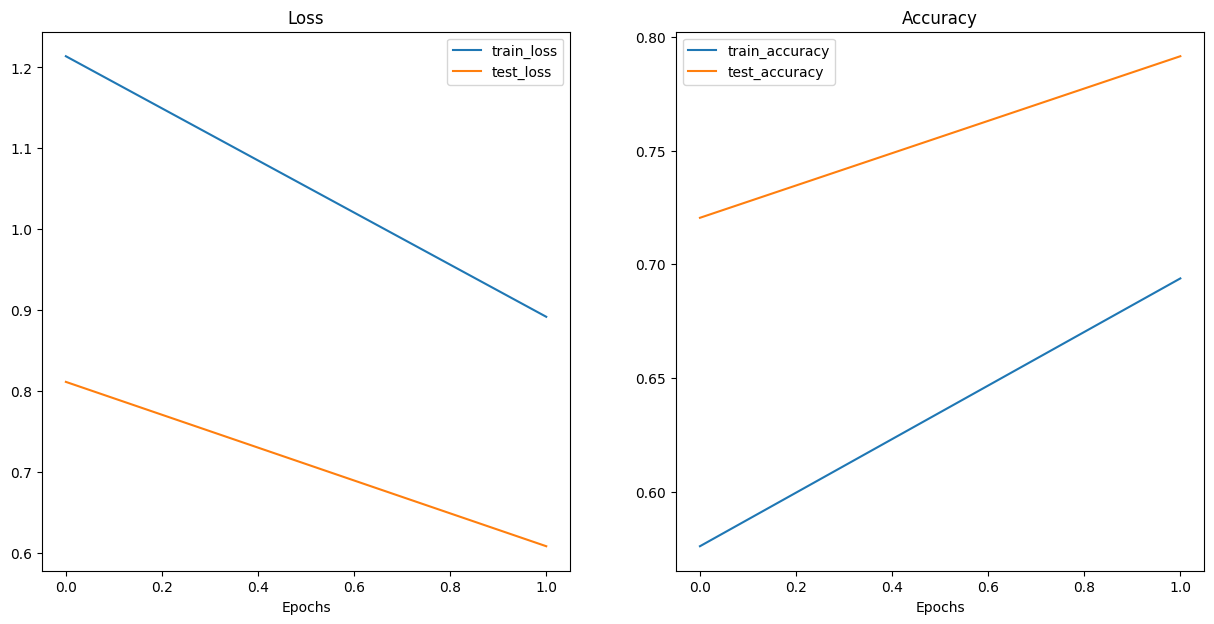

In [10]:
from modular.utils import plot_loss_curves
plot_loss_curves(results)

In [11]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
  from google.colab import files
  files.download('finetune.AMLResnet50_FastAI.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Training find tunning Resnet 50 Fast AI


In [12]:
import zipfile
from pathlib import Path
import torch
import matplotlib.pyplot as plt

In [13]:
try:
    import google.colab
    IN_COLAB = True
    ! pip install torchvision
    ! pip install torchinfo
    
    from google.colab import drive
    drive.mount('/content/drive')

    !rm -rf data
    data_path = Path('/content/drive/MyDrive/AML/dataset_CIFAR10.zip')
    with zipfile.ZipFile(data_path,"r") as zip_ref:
        zip_ref.extractall("data")

    !rm -rf modular
    data_path = Path('/content/drive/MyDrive/AML/modular.zip')
    with zipfile.ZipFile(data_path,"r") as zip_ref:
        zip_ref.extractall(".")

    !rm -rf trained
    !cp -rf /content/drive/MyDrive/AML/trained ./trained
except:
    IN_COLAB = False

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import torch
from pathlib import Path

saved_data = torch.load(Path('trained/finetune.AMLResnet50_FastAI.pth'))
saved_data.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc', 'epoch', 'optimizer', 'model'])

In [17]:
import torch
import modular.datasets as datasets
import modular.models as models 
from pathlib import Path
from modular.engine import train
import torchvision.transforms as transforms
from modular.utils import set_seeds

set_seeds(seed=42)

# Model
net = models.AMLResnet50_FastAI(out_dim=10)
# Recover state dict
state_dict = saved_data['model']
# Load saved state dict into the model
net.load_state_dict(state_dict)
# Freeze base
#net.freeze_base()

train_transforms, validate_transforms = net.transforms, net.transforms

augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomPerspective(),
])

train_transforms = transforms.Compose([augmentation, train_transforms])

# Optimizer
lr = 0.001
optimizer = torch.optim.Adam(params=net.parameters(),
                             lr=lr)

# Criterion
criterion = torch.nn.CrossEntropyLoss()

# Number of epochs to train the model
epochs = 10

# Default device to train model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

# Where the model is saved
save_as = Path('AMLResnet50_FastAI.pth')

# Mini batch
batch_size=256

train_dataloader = datasets.get_dataloader(folder_root='data/train',
                                           transformer=train_transforms,
                                           batch_size=batch_size,
                                           suffle=True)
validate_dataloader = datasets.get_dataloader(folder_root='data/validation',
                                           transformer=validate_transforms,
                                           batch_size=batch_size,
                                           suffle=False)

In [18]:
results = train(model=net,
                train_dataloader=train_dataloader,
                test_dataloader=validate_dataloader,
                optimizer=optimizer,
                criterion=criterion,
                epochs=epochs,
                device=device,
                save_as=save_as)

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 1 | train_loss: 0.7088 | train_acc: 0.7539 | test_loss: 0.5279 | test_acc: 0.8172


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 2 | train_loss: 0.5927 | train_acc: 0.7954 | test_loss: 0.5209 | test_acc: 0.8232


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 3 | train_loss: 0.6735 | train_acc: 0.7655 | test_loss: 0.4991 | test_acc: 0.8260


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 4 | train_loss: 0.6660 | train_acc: 0.7672 | test_loss: 0.4933 | test_acc: 0.8296


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 5 | train_loss: 0.6504 | train_acc: 0.7719 | test_loss: 0.4860 | test_acc: 0.8287


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 6 | train_loss: 0.6486 | train_acc: 0.7727 | test_loss: 0.4806 | test_acc: 0.8319


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 7 | train_loss: 0.6475 | train_acc: 0.7755 | test_loss: 0.4810 | test_acc: 0.8327


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 8 | train_loss: 0.6464 | train_acc: 0.7732 | test_loss: 0.4815 | test_acc: 0.8317


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 9 | train_loss: 0.6390 | train_acc: 0.7785 | test_loss: 0.4820 | test_acc: 0.8339


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 10 | train_loss: 0.6330 | train_acc: 0.7788 | test_loss: 0.4743 | test_acc: 0.8347


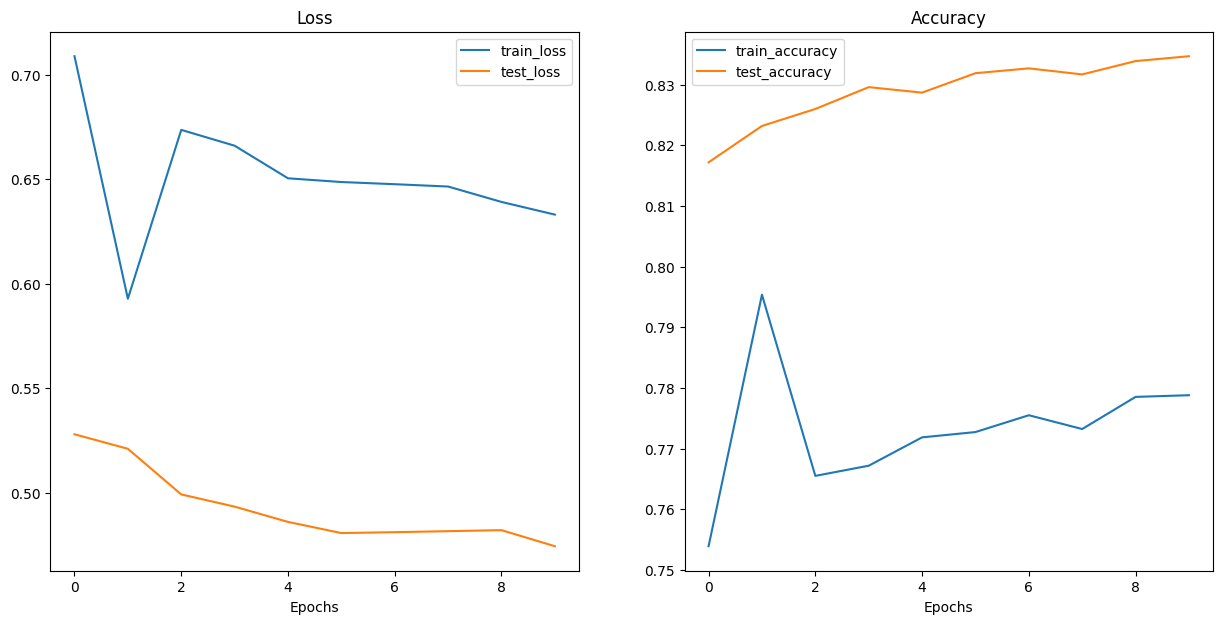

In [19]:
from modular.utils import plot_loss_curves
plot_loss_curves(results)

In [20]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
  from google.colab import files
  files.download('AMLResnet50_FastAI.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>